# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Признаки  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
Price — цена (евро)  

### Импорт инструментов и данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


from catboost import Pool, CatBoostRegressor, cv




In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head(15)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


### Общая Предобработка данных

In [4]:
print(df.info())
print(sum(df.duplicated()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


 <b>Вывод</b>    
1. В столбце Цена присутсвуют значения с нулевой стоимостью
2. В столбце RegistrationYear есть слишком большие значения года регистрации.
3. В столбце Power есть слишком большие  значения мощности двигателя.
4. В столбце Kilometer более 50% с пробегом 150000 скорее всего это связано с некими правилами заполнения формы
Для модели значимы в связи с прямым влиянием на стоимость:
1. Brand
2. RegistrationYear
3. Gearbox
4. Model
5. Power
6. Kilometer
7. FuelType
8. VehicleType 
9. NotRepaired

In [6]:
F_df =  df[['VehicleType','RegistrationYear',
                         'Gearbox','Power',
                         'Model','Kilometer',
                         'FuelType', 'Brand',
                         'Repaired','Price']]
F_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  354369 non-null  int64 
 2   Gearbox           334536 non-null  object
 3   Power             354369 non-null  int64 
 4   Model             334664 non-null  object
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   Repaired          283215 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
display(F_df.describe())

,RegistrationYear,Power,Kilometer,Price
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,2004.234448,110.094337,128211.172535,4416.656776
std,90.227958,189.850405,37905.341530,4514.158514
min,1000.000000,0.000000,5000.000000,0.000000
25%,1999.000000,69.000000,125000.000000,1050.000000
50%,2003.000000,105.000000,150000.000000,2700.000000
75%,2008.000000,143.000000,150000.000000,6400.000000
max,9999.000000,20000.000000,150000.000000,20000.000000


In [8]:
F_df.duplicated().sum()

45040

In [9]:
F_df = F_df.drop_duplicates()
F_df.duplicated().sum()

0

<b>Вывод</b>   
дубликаты устранили, далее требуется избавиться от пропусков значений в столбцах  
(VehicleType/RegistrationYear/Gearbox/Power/FuelType/Repaired/Model )

### Исследовательский анализ

#### Функции

In [10]:
def analysis_BAR(adata_in, chapter, heading, Х, Y, bins):
    print(adata_in[chapter].describe())
    adata_ini = adata_in[chapter].value_counts(ascending=True)
    display(adata_ini)
    adata_ini.plot.bar(figsize=(10, 5), ec='black')
    plt.title(heading)
    plt.xlabel(Х)
    plt.ylabel(Y)
    plt.legend(loc=2)
    plt.figure(figsize=(10,5))

In [11]:
def analysis_HIST(adata_in, chapter, heading, Х, Y, bins):
    print(adata_in[chapter].describe())
    #adata_ini = adata_in.groupby(chapter).mean()
    #display(adata_in[chapter].head(5))
    plt.title(heading)
    plt.xlabel(Х)
    plt.ylabel(Y)
    
    plt.hist(x=adata_in[chapter], bins=bins )
    plt.figure(figsize=(10,5))
    #plt.show() 

Для упрощения работы

#### Power

count    309329.000000
mean        110.976908
std         200.969473
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


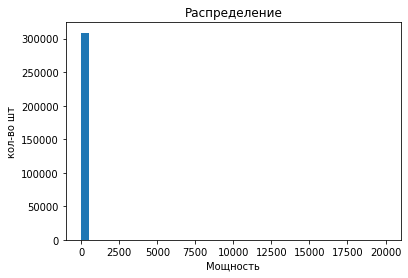

<Figure size 720x360 with 0 Axes>

In [12]:
analysis_HIST(F_df,
             'Power',
             'Распределение',
             'Мощность',
             'кол-во шт',
             40)

In [13]:
F_df = F_df.query('1 < Power')

In [14]:
F_df.loc[F_df['Power'] >= 400, 'Power'] = (F_df['Power']/100)
F_df.loc[F_df['Power'] < 50, 'Power'] = (F_df['Power']*10) 

In [15]:
#F_df = F_df.query(' Power < 500')

count    273319.000000
mean        127.206986
std          64.965457
min          20.000000
25%          82.000000
50%         115.000000
75%         150.000000
max         490.000000
Name: Power, dtype: float64


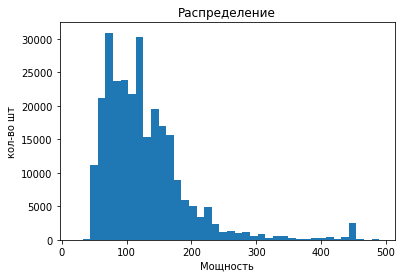

<Figure size 720x360 with 0 Axes>

In [16]:
analysis_HIST(F_df,
             'Power',
             'Распределение',
             'Мощность',
             'кол-во шт',
             40)

#### VehicleType

count     251783
unique         8
top        sedan
freq       72518
Name: VehicleType, dtype: object


other           2528
suv             9958
coupe          13660
convertible    17075
bus            23728
wagon          52232
small          60084
sedan          72518
Name: VehicleType, dtype: int64

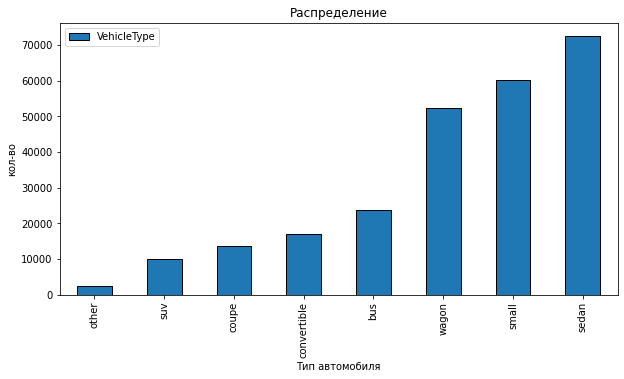

<Figure size 720x360 with 0 Axes>

In [17]:
 
analysis_BAR(F_df,
             'VehicleType',
             'Распределение',
             'Тип автомобиля',
             'кол-во',
             40)

In [18]:
display(F_df['VehicleType'].isna().sum())

21536

In [19]:
F_df_pvt = F_df.pivot_table(index=['VehicleType'],columns=['Brand'],values=['Price'],aggfunc=['count'])
F_df_pvt = F_df_pvt['count']['Price']

In [20]:
def fillna1(row, row_number, F_df_pvt):
    brand = row[7]
    value = row[row_number]
    if row[row_number] == 0:
        value = F_df_pvt[brand].idxmax()
    return value

In [21]:
F_df.fillna({'VehicleType':0},inplace=True) 
F_df['VehicleType'] = F_df.apply(
                                fillna1, 
                                args=[0, F_df_pvt],
                                axis=1)
display(F_df['VehicleType'].isna().sum())

0

count     273319
unique         8
top        sedan
freq       82615
Name: VehicleType, dtype: object


other           2528
suv            10109
coupe          13660
convertible    17097
bus            23793
wagon          54216
small          69301
sedan          82615
Name: VehicleType, dtype: int64

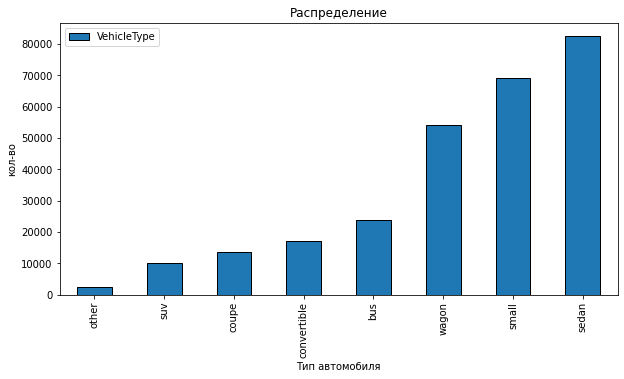

<Figure size 720x360 with 0 Axes>

In [22]:
analysis_BAR(F_df,
             'VehicleType',
             'Распределение',
             'Тип автомобиля',
             'кол-во',
             40)

 <b>Вывод</b>   

#### FuelType

count     252893
unique         7
top       petrol
freq      169245
Name: FuelType, dtype: object


electric        77
other           92
hybrid         197
cng            466
lpg           4502
gasoline     78314
petrol      169245
Name: FuelType, dtype: int64

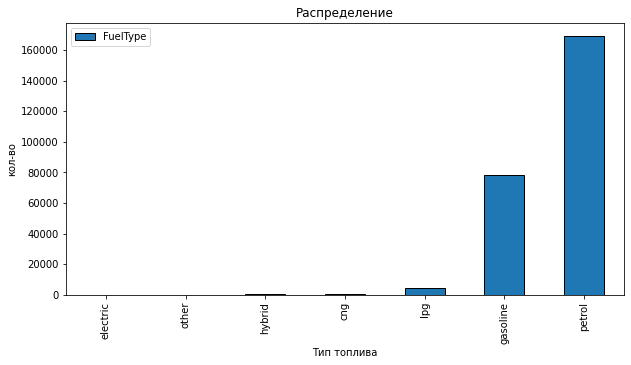

<Figure size 720x360 with 0 Axes>

In [23]:
analysis_BAR(F_df,
             'FuelType',
             'Распределение',
             'Тип топлива',
             'кол-во',
             40)

In [24]:
display(F_df['FuelType'].isna().sum())

20426

In [25]:
F_df_pvt2 = F_df.pivot_table(index=['FuelType'],columns=['Brand'],values=['Price'],aggfunc=['count'])
F_df_pvt2 = F_df_pvt2['count']['Price']

In [26]:
def fillna2(row, row_number, F_df_pvt):
    brand = row[7]
    value = row[row_number]
    if row[row_number] == 0:
        value = F_df_pvt[brand].idxmax()
    return value

In [27]:
F_df.fillna({'FuelType':0},inplace=True) 
F_df['FuelType'] = F_df.apply(
                                fillna2, 
                                args=[0, F_df_pvt2],
                                axis=1)
display(F_df['FuelType'].isna().sum())

0

count     273319
unique         8
top        sedan
freq       82615
Name: FuelType, dtype: object


other           2528
suv            10109
coupe          13660
convertible    17097
bus            23793
wagon          54216
small          69301
sedan          82615
Name: FuelType, dtype: int64

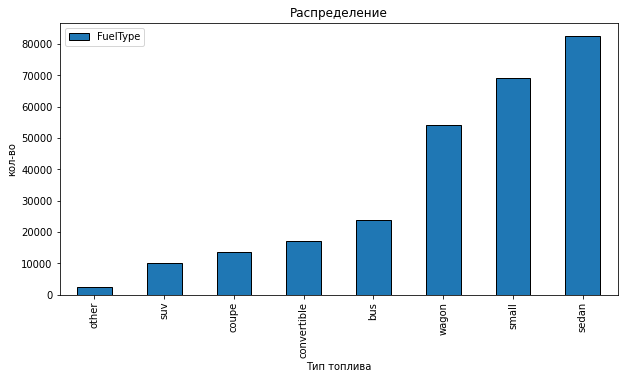

<Figure size 720x360 with 0 Axes>

In [28]:
analysis_BAR(F_df,
             'FuelType',
             'Распределение',
             'Тип топлива',
             'кол-во',
             40)

 <b>Вывод</b>   

#### RegistrationYear

In [29]:
F_df.groupby(by='RegistrationYear')['RegistrationYear'].count()
 

RegistrationYear
1000    8
1200    1
1234    1
1400    1
1500    1
       ..
6500    1
8000    1
8200    1
9000    1
9999    1
Name: RegistrationYear, Length: 114, dtype: int64

count    273319.000000
mean       2003.576692
std          36.816511
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


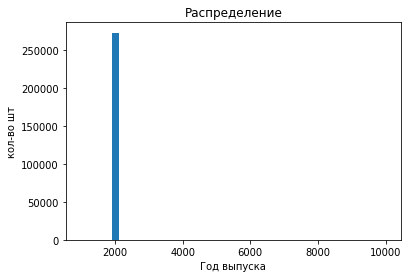

<Figure size 720x360 with 0 Axes>

In [30]:
 

analysis_HIST(F_df,
             'RegistrationYear',
             'Распределение',
             'Год выпуска',
             'кол-во шт',
             40)

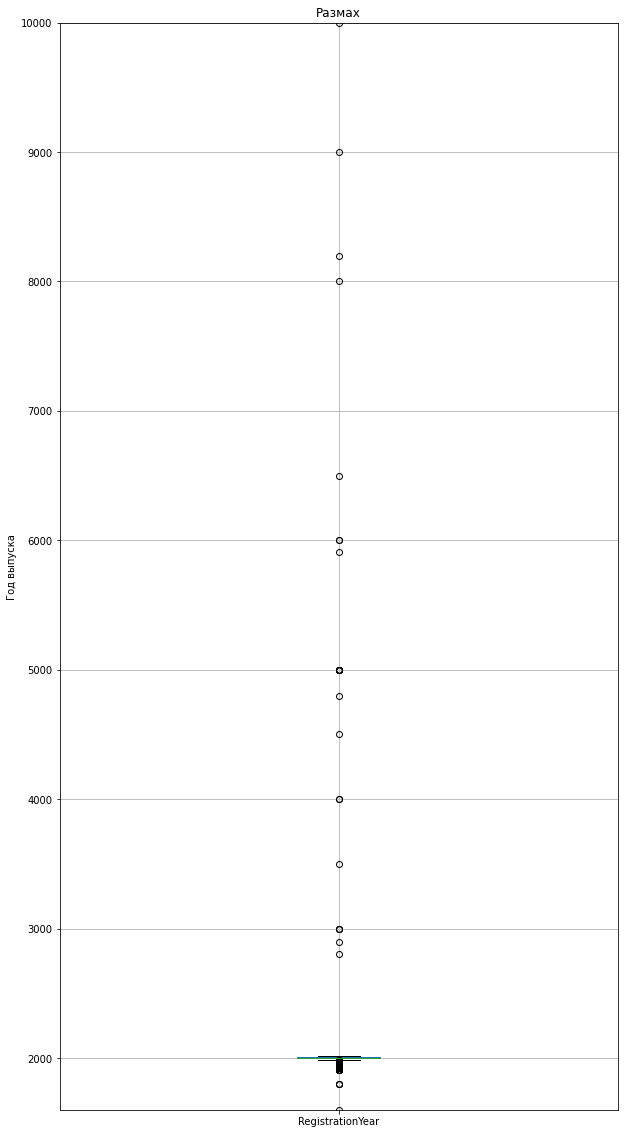

In [31]:
F_df.boxplot(column='RegistrationYear', figsize=(10, 20))
plt.title('Размах')
plt.ylim(1600, 10000)
plt.ylabel('Год выпуска')
plt.show()

In [32]:
F_df.loc[F_df['RegistrationYear'] >= 2016, 'RegistrationYear'] = (F_df['RegistrationYear']/100)+1920
F_df.loc[F_df['RegistrationYear'] <= 1900, 'RegistrationYear'] = (F_df['RegistrationYear']/100)+1920

In [33]:
F_df = F_df.query('1960 < RegistrationYear < 2016')

In [34]:
F_df['RegistrationYear'].describe()

count    256602.000000
mean       2002.507522
std           6.327228
min        1961.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: RegistrationYear, dtype: float64

count    256602.000000
mean       2002.507522
std           6.327228
min        1961.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: RegistrationYear, dtype: float64


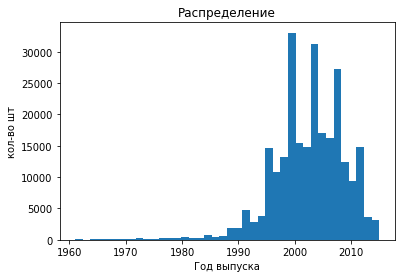

<Figure size 720x360 with 0 Axes>

In [35]:
analysis_HIST(F_df,
             'RegistrationYear',
             'Распределение',
             'Год выпуска',
             'кол-во шт',
             40)

#### Gearbox

In [36]:
F_df.fillna({'Gearbox':'manual'},  inplace=True)
F_df['Gearbox'].isna().mean()

0.0

In [37]:
F_df['bool_gearbox'] = 0
F_df.loc[F_df['Gearbox'] == 'manual', 'bool_gearbox'] = 1

 <b>Вывод</b>   

#### Repaired

In [38]:
F_df.fillna({'Repaired':'yes'},  inplace=True)
F_df['Repaired'].isna().mean()


0.0

In [39]:
F_df['bool_Repaired'] = 0
F_df.loc[F_df['Repaired'] == 'not', 'bool_Repaired'] = 1

 <b>Вывод</b>   

#### Model

In [40]:
F_df.fillna({'Model':'unknown'},  inplace=True)
F_df['Model'].isna().mean()


0.0

 <b>Вывод</b>   

#### Price

count    256602.000000
mean       4894.424626
std        4678.259810
min           0.000000
25%        1300.000000
50%        3200.000000
75%        7000.000000
max       20000.000000
Name: Price, dtype: float64


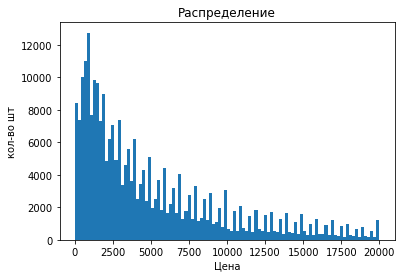

<Figure size 720x360 with 0 Axes>

In [41]:
analysis_HIST(F_df,
             'Price',
             'Распределение',
             'Цена',
             'кол-во шт',
             100)

In [42]:
F_df = F_df.query('500 <Price < 11500')


Такие ограничения в связи с тем что значения меньше 500 долларов не реальны для современности и не отражают реальную стоимость товара. Скорее всего подразумевается дальнейший торг  
А больше 11500 тысяч уже не такое большое количество авто, что в дальнейшем повредит обучаемой модели  

count    203787.000000
mean       3923.771948
std        2859.702634
min         501.000000
25%        1500.000000
50%        3000.000000
75%        5850.000000
max       11499.000000
Name: Price, dtype: float64


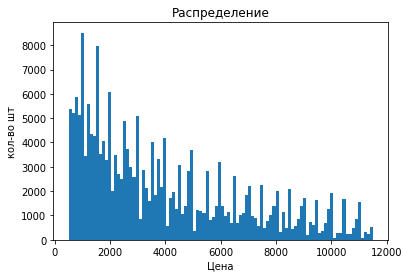

<Figure size 720x360 with 0 Axes>

In [43]:
analysis_HIST(F_df,
             'Price',
             'Распределение',
             'Цена',
             'кол-во шт',
             100)

### Финальная проверка и подготовка данных

In [44]:
F_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203787 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       203787 non-null  object 
 1   RegistrationYear  203787 non-null  float64
 2   Gearbox           203787 non-null  object 
 3   Power             203787 non-null  float64
 4   Model             203787 non-null  object 
 5   Kilometer         203787 non-null  int64  
 6   FuelType          203787 non-null  object 
 7   Brand             203787 non-null  object 
 8   Repaired          203787 non-null  object 
 9   Price             203787 non-null  int64  
 10  bool_gearbox      203787 non-null  int64  
 11  bool_Repaired     203787 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 20.2+ MB


In [45]:
F_df.describe()

,RegistrationYear,Power,Kilometer,Price,bool_gearbox,bool_Repaired
count,203787.000000,203787.000000,203787.000000,203787.000000,203787.000000,203787.0
mean,2002.216658,122.404903,130376.152551,3923.771948,0.812839,0.0
std,5.815931,58.381809,34535.050563,2859.702634,0.390042,0.0
min,1961.000000,20.000000,5000.000000,501.000000,0.000000,0.0
25%,1999.000000,82.000000,125000.000000,1500.000000,1.000000,0.0
50%,2003.000000,110.000000,150000.000000,3000.000000,1.000000,0.0
75%,2006.000000,147.000000,150000.000000,5850.000000,1.000000,0.0
max,2015.000000,490.000000,150000.000000,11499.000000,1.000000,0.0


In [46]:
F_df.pop('Repaired')
F_df.pop('Gearbox')
 

2           auto
3         manual
4         manual
5         manual
6         manual
           ...  
354360    manual
354362    manual
354366      auto
354367    manual
354368    manual
Name: Gearbox, Length: 203787, dtype: object

### Вывод

Данные проанализировали и отследили распределение

Обработаны пропуски,аномалии и некорректные значения (выбросы и т.д)

Выбраны необходимые данные для обучения модели

Заменены категориальные признаки данных на численые

Подготовлены наборы данных

## Обучение моделей

In [47]:
ohe_columns = ['VehicleType', 'Model', 'FuelType','Brand']
ord_columns = ['Gearbox', 'Repaired' ]
num_columns = ['RegistrationYear', 'Power','Kilometer']
RANDOM_STATE=1515

In [48]:
X  = F_df.drop('Price', axis=1)
Y  = F_df['Price']
 


In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=RANDOM_STATE)

#ORD_train = ORD.loc[X_train.index, :]
#ORD_test = ORD.loc[X_test.index, :]

#OHE_train = OHE.loc[X_train.index, :]
#OHE_test = OHE.loc[X_test.index, :]

In [50]:
encoder2  = OneHotEncoder(drop='first')


In [51]:
encoder = OrdinalEncoder()
#encoder2  = OneHotEncoder(drop='first')

OE_train = X_train[ohe_columns]


ORD_train = X_train.copy()
for column in ohe_columns:
    ORD_train[column] = OE_train[column]

OE_train = pd.DataFrame(encoder.fit_transform(OE_train),
                                columns=OE_train.columns, 
                                index=OE_train.index)
#OHE_train = pd.get_dummies(X_train, drop_first=True)
OHE_train = encoder2.fit_transform(X_train[ohe_columns])

In [52]:
OE_test = X_test[ohe_columns]

ORD_test = X_test.copy()
for column in ohe_columns:
    ORD_test[column] = OE_test[column]

OE_test = pd.DataFrame(encoder.transform(OE_test),
                                columns=OE_test.columns, 
                                index=OE_test.index)

#OHE_test = pd.get_dummies(X_test, drop_first=True)
OHE_test = encoder2.transform(X_test[ohe_columns])

In [53]:
#OHE_train.head()

In [54]:
#OHE_test.head()

 <b>Вывод</b>   

### LinearRegression

In [55]:
%%time
model_lr1 = LinearRegression()
 
RMSE_lr1= (cross_val_score(model_lr1, OHE_train, Y_train , cv=5, scoring='neg_mean_squared_error').mean() * -1)** 0.5
print(f'Best score: {RMSE_lr1}')

Best score: 2518.6639197626287
CPU times: user 32.7 s, sys: 34.3 s, total: 1min 6s
Wall time: 1min 6s


In [56]:
%%time

model_lr = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", model_lr)])
RMSE_LR_1 = (cross_val_score(pipeline, OHE_train, Y_train , cv=5, scoring='neg_mean_squared_error').mean() * -1)** 0.5
print(f'Best score: {RMSE_LR_1}')

Best score: nan
CPU times: user 35.5 ms, sys: 0 ns, total: 35.5 ms
Wall time: 34.7 ms


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/conda/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.

In [57]:
%%time

# Попробуем с масштабируемыми признаками
model_lr2 = LinearRegression()
scale = RobustScaler()
pipeline = Pipeline([("robust_scaller", scale),("linear_regression", model_lr2)])


RMSE_LR_2 = (cross_val_score(pipeline,
                                OHE_train, 
                                Y_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE LinearRegression =', RMSE_LR_2)

RMSE LinearRegression = nan
CPU times: user 60.5 ms, sys: 39 µs, total: 60.5 ms
Wall time: 58.7 ms


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/conda/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.

 <b>Вывод</b>
 
 применение масштабирования через пайплайн ухудшает модель в случае линейной регрессии

### CatBoostRegressor

In [58]:
%%time

model_CAT = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],'random_state':[RANDOM_STATE], 'verbose':[False]}]

clf = GridSearchCV(model_CAT, hyperparams, scoring='neg_mean_squared_error')

clf.fit(OE_train, Y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print( params)

RMSE_CAT1 = (clf.best_score_* -1)** 0.5
print(RMSE_CAT1)

{'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}
{'learning_rate': 0.5, 'random_state': 1515, 'verbose': False}
{'learning_rate': 0.8, 'random_state': 1515, 'verbose': False}
2456.2784439996494
CPU times: user 3min 33s, sys: 2.17 s, total: 3min 36s
Wall time: 3min 53s


In [59]:
%%time
model_CAT1 = CatBoostRegressor(learning_rate=0.5,
                              iterations = 100,
                              random_state=1515, 
                              verbose=False, 
                              cat_features=ohe_columns) 
 
RMSE_CAT2  = (cross_val_score(model_CAT1,
                                X_train, 
                                Y_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE', RMSE_CAT2)

Mean RMSE 1280.4727026027178
CPU times: user 17.7 s, sys: 189 ms, total: 17.9 s
Wall time: 21.1 s


### LGBM

In [60]:
%%time
model_LGBM = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[1515]}]


clf = GridSearchCV(model_LGBM, hyperparams, scoring='neg_mean_squared_error')
clf.fit(OE_train, Y_train)
RMSE_LGBM = (clf.best_score_* -1)** 0.5
print('Mean RMSE', RMSE_LGBM)

Mean RMSE 2456.6254673985663
CPU times: user 56.9 s, sys: 0 ns, total: 56.9 s
Wall time: 57.5 s


### Лучшие модели и предсказания на них

#### linear

In [61]:
%%time
 
model_lr1.fit(OHE_train, Y_train)


CPU times: user 8.46 s, sys: 8.67 s, total: 17.1 s
Wall time: 17.2 s


LinearRegression()

#### CatBoostRegressor1

In [63]:
%%time
model_CAT = CatBoostRegressor(learning_rate=0.5, 
                          random_state=1515, 
                          verbose=False) 
model_CAT.fit(OE_train, Y_train)


CPU times: user 16.6 s, sys: 139 ms, total: 16.8 s
Wall time: 17.8 s


#### CatBoostRegressor2

In [65]:
%%time

model_CAT1.fit(X_train, Y_train)

CPU times: user 4.39 s, sys: 56.1 ms, total: 4.45 s
Wall time: 5.05 s


#### LGBMRegressor

In [67]:
%%time

model = LGBMRegressor(learning_rate=0.3, 
                      num_leaves=100, 
                      random_state=1515)
model.fit(OHE_train, Y_train)


CPU times: user 7.2 s, sys: 0 ns, total: 7.2 s
Wall time: 7.15 s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=1515)

## Анализ моделей

In [73]:
%%time
predict_linear = model_lr1.predict(OHE_train)
 

CPU times: user 3.34 ms, sys: 0 ns, total: 3.34 ms
Wall time: 2.11 ms


In [64]:
%%time
CAT_predict_1 = model_CAT.predict(OHE_train)
print(CAT_predict_1)



[1707.33715863 1707.33715863 1707.33715863 ... 3964.90886574 1707.33715863
 1707.33715863]
CPU times: user 216 ms, sys: 725 µs, total: 216 ms
Wall time: 214 ms


In [76]:
%%time
CAT_predict_2 = model_CAT1.predict(X_train)
print(CAT_predict_1)

[1707.33715863 1707.33715863 1707.33715863 ... 3964.90886574 1707.33715863
 1707.33715863]
CPU times: user 141 ms, sys: 3.35 ms, total: 145 ms
Wall time: 142 ms


In [68]:
%%time
LGBM_predict = model.predict(OHE_train)


CPU times: user 2.42 s, sys: 0 ns, total: 2.42 s
Wall time: 2.42 s


In [78]:
#Форму для таблицы честно взял из стороннего источника, потому что искал как удобнее и нагляднее все оформить

IND = ['LinearRegression',
         'CatBoostRegressor с кодированием',
         'CatBoostRegressor на оригинальных данных',
         'LGBMRegressor']
INFO = {'RMSE, евро':[RMSE_lr1,
                            RMSE_CAT1,
                            RMSE_CAT2,
                            RMSE_LGBM],
        'Время обучения, сек':[67,
                                     210,
                                     20.9,
                                     98],
        #'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
        #                                        final_RMSE_CAT1,
        #                                        final_RMSE_CAT2,
        #                                        final_RMSE_LGBM],
        'Время обучения модели, сек':[16.6,
                                      16.3,
                                      4.35,
                                      5.76],
        'Время предсказания модели, сек':[0.0034,
                                          0.216,
                                         0.145,
                                         2.42]
       }

data = pd.DataFrame(data=INFO, index=IND)
data['Рейтинг RMSE'] = (data['RMSE, евро'].min() /
                  data['RMSE, евро'])
data['Рейтинг времени обучения'] = (data['Время обучения модели, сек'].min() / 
                              data['Время обучения модели, сек'])
data['Рейтинг времени предсказания'] = (data['Время предсказания модели, сек'].min() / data['Время предсказания модели, сек'])
data['Итоговый рейтинг'] = (data['Рейтинг RMSE'] +
                                   data['Рейтинг времени обучения'] +
                                   data['Рейтинг времени предсказания'])
display(data)

,"RMSE, евро","Время обучения, сек","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,2518.663920,67.0,16.60,0.0034,0.508394,0.262048,1.000000,1.770442
CatBoostRegressor с кодированием,2456.278444,210.0,16.30,0.2160,0.521306,0.266871,0.015741,0.803918
CatBoostRegressor на оригинальных данных,1280.472703,20.9,4.35,0.1450,1.000000,1.000000,0.023448,2.023448
LGBMRegressor,2456.625467,98.0,5.76,2.4200,0.521232,0.755208,0.001405,1.277846


<b>Выводы</b>   
 Модель <b>CatBoostRegressor с кодированием</b>- обладает наибольшей продолжительностью вычислений, но требует много времени на работу  
 Модель<b>CatBoostRegressor на оригинальных данных</b> - Наиболее быстродейственная модель  
 Модель<b>LGBMRegressor</b> - Обеспечивает вторую по скорости работу, при меньшей чем у первого указанного варианта точности, однако за счет большего быстродействия выигрывает иная модель.
  Модели<b>LinearRegression</b> не применима, так как не попадает в указанные в задании рамки RMSE<2500 
 
 Модель  <b>CatBoostRegressor на оригинальных данных</b> - наиболеее эффективная по итоговому рейтингу модель, обеспечивающая максимальную точность и быстродействие

In [70]:
%%time

model_CAT1.fit(X_train, Y_train)

CPU times: user 4.39 s, sys: 0 ns, total: 4.39 s
Wall time: 5.05 s


In [71]:
%%time
CAT_predict_2 = model_CAT1.predict(X_test)



CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 48 ms


In [72]:
final_RMSE_CAT2=mean_squared_error(Y_test, CAT_predict_2) ** 0.5
print('Показатель RMSE лучшей модели', final_RMSE_CAT2)

Показатель RMSE лучшей модели 1269.6037236336692


## Общий вывод  

В проекте выполнены все заданные цели, ниже описан ход работы.  
 1. Импортированы инструменты, библиотеки и данные для работы.
 2. Проведена предварительная предобработка с выделением нужных признаков и удалением дубликатов в данных
 3. Проведен исследовательский анализ выделенных признаков, включая целевой.
 4. Устранены выбросы и аномалии в значениях, изменены типы данных в отдельных столбцах
 5. Проведена финальная проверка данных
 6. Произведена подготовка и кодировка данных для формирвоания выборок.
 7. Обучено несколько моделей с перебором гиперпараметров в различиных вариациях.
 8. Произведены расчеты продолжительности и эффективности запрошенных операций на моделях.
 9. Данные собраны в единую сводную таблицу.
 10. Сделан вывод о наиболее эффективных моделях.
 
 <b>CatBoostRegressor на оригинальных данных</b> - наиболеее эффективная по итоговому рейтингу модель, обеспечивающая максимальную точность и быстродействие

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей